In [0]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.datasets import cifar10

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [0]:
class DCGAN(object):
    def __init__(self, img_rows=32, img_cols=32, channel=3):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(10))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))
        self.G.add(Reshape((dim, dim, depth)))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(128, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(64, 5))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))

        self.G.add(Conv2DTranspose(32, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(3, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = Adam()
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='categorical_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = Adam()
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='categorical_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM


In [0]:
class CIFAR10_DCGAN(object):
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channel = 3
        (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
        self.x_train = train_features 
        self.x_labels = train_labels
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 3).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            index = np.random.randint(0,self.x_train.shape[0], size=batch_size)
            images_train = self.x_train[index, :, :, :]/255
            images_labels = self.x_labels[index, :]/255
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.zeros([2*batch_size, 10])
            y[0:batch_size, :] = images_labels
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.zeros([batch_size,10])
            y[:,0]=1
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=6, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[[29,30,35,50,78,93], :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols, self.channel])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 256)         819456    
__________

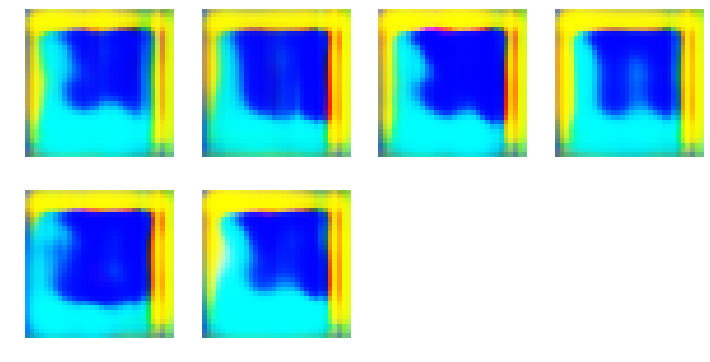

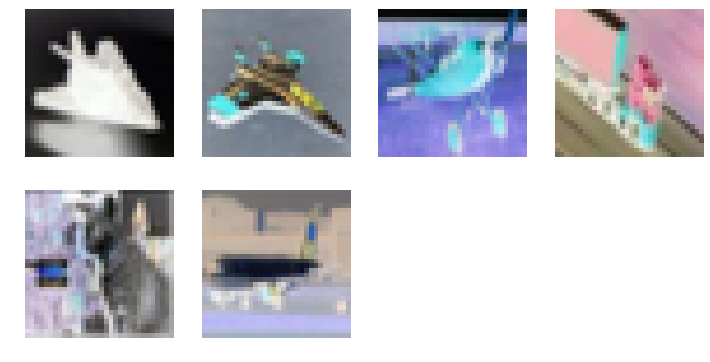

In [0]:
if __name__ == '__main__':
    cifar10_dcgan = CIFAR10_DCGAN()
    timer = ElapsedTimer()
    cifar10_dcgan.train(train_steps=150, batch_size=256, save_interval=0)
    timer.elapsed_time()
    cifar10_dcgan.plot_images(fake=True)
    cifar10_dcgan.plot_images(fake=False, save2file=False)

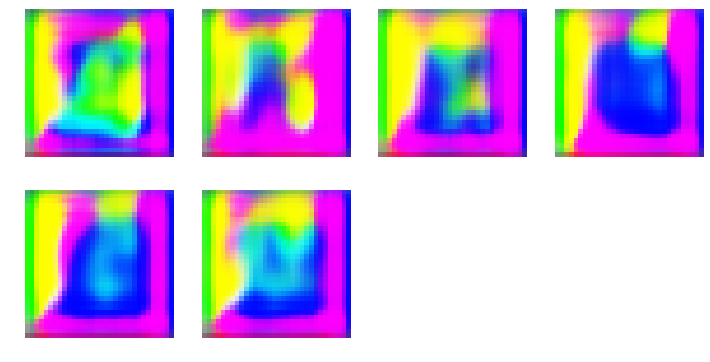

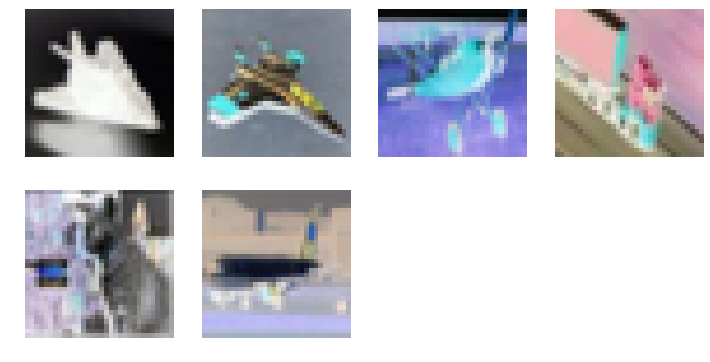

In [0]:
cifar10_dcgan.plot_images(fake=True)
cifar10_dcgan.plot_images(fake=False, save2file=False)